In [1]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
sys.path.append('/tf/crypto_prediction_ml_dl/script')
from trino_operations import trino_operator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.losses import mean_squared_error
from sklearn import metrics

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# run eagerly should be set to true. 
tf.config.run_functions_eagerly(True)

import copy


warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()



def create_dataframe_from_query(query,column_list):
    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        indicators_query_result[int(idx)] = row_data

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=column_list
    )

    return indicators_raw_df


def wmae_loss(y_true, y_pred):
    
    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    def calculate_gain(data):
        # Set the first gain value is 1 since there is no past data for the first data.
        gain_data = np.append(np.ndarray([1]), (data[1:] / data[:-1]) - 1.0)
        return gain_data
    
    l = 5.0
    
    diff = y_true[:,0] - y_pred[:,0]
    
    w_true = step_function(y_true[:, 1])
    w_pred = step_function(calculate_gain(y_pred[:, 1]))
    
    # Weighted mean absolute error
    threshold = w_true * diff
    wae = step_function(threshold) * ((l + abs(w_true - w_pred)) * abs(diff)) \
            + (1 - step_function(threshold)) * ((1/l) * abs(diff))
    wmae = sum(wae) / wae.shape[0]
    
    return wmae

def wmse_loss(y_true, y_pred):
    
    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    def calculate_gain(data):
        # Set the first gain value is 1 since there is no past data for the first data.
        gain_data = np.append(np.ndarray([1]), (data[1:] / data[:-1]) - 1.0)
        return gain_data
    
    l = 1.5

    # -1.0 <= absolute_diff <= 1.0
    absolute_diff = y_true[:,0] - y_pred[:,0]
    
    # 1.0 <= squared_diff
    squared_diff = step_function(absolute_diff) * (absolute_diff+2)**2 \
            + (1 - step_function(absolute_diff)) * (absolute_diff-2)**2
    
    w_true = step_function(y_true[:, 1])
    w_pred = step_function(calculate_gain(y_pred[:, 1]))
    
    # Weighted mean squared error
    threshold = w_true * absolute_diff
    wse = step_function(threshold) * ((l + abs(w_true - w_pred)) * abs(squared_diff)) \
            + (1 - step_function(threshold)) * ((1/l) * abs(squared_diff))
    wmse = sum(wse) / wse.shape[0]
    
    return wmse


def f1_metric(true, pred):

    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    def calculate_gain(data):
        # Set the first gain value is 1 since there is no past data for the first data.
        gain_data = np.append(np.ndarray([1]), (data[1:] / data[:-1]) - 1.0)
        return gain_data
    
    g_true = step_function(true[:, 1])
    g_pred = step_function(calculate_gain(pred[:, 0]))

    ground_positives = K.cast(K.sum(g_true, axis=0), "float") + K.epsilon()       # = TP + FN
    pred_positives = K.cast(K.sum(g_pred, axis=0), "float") + K.epsilon()         # = TP + FP
    true_positives = K.cast(K.sum(g_true * g_pred, axis=0), "float") + K.epsilon()  # = TP
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        #still with shape (4,)

    return f1

2023-11-12 02:50:26.905425: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-12 02:50:26.931155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-12 02:50:27.823580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-12 02:50:27.827522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-12 02:50:27.827645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
########################
# Create BTC_USDT featrue dataframe
########################
query = f"""
    with 
    ohlcv_minute_data as
    (
        select 
            open,
            high,
            low,
            close,
            amount as total_volume,
            quantity as total_quantity,
            tradeCount as total_trade_count,
            date_trunc('minute',ts_create_utc) as ts
        from 
            hive.crypto_raw.candles_minute 
        where 
            id = 'BTC_USDT'
    ),
    buy_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as buy_trade_count,
            sum(amount) as sum_buy_taker_amount,
            sum(quantity)  as sum_buy_taker_quantity,
            avg(price) as avg_buy_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'buy'
        group by
            1
    ), 
    sell_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as sell_trade_count,
            sum(amount) as sum_sell_taker_amount,
            sum(quantity) as sum_sell_taker_quantity,
            avg(price) as avg_sell_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'sell'
        group by
            1
    )
    select
        a.open as open,
        a.high as high,
        a.low as low,
        a.close as close,
        a.total_volume as total_volume,
        a.total_quantity as total_quantity,
        a.total_trade_count as total_trade_count,
        b.buy_trade_count as buy_trade_count,
        b.sum_buy_taker_amount as sum_buy_taker_amount,
        b.sum_buy_taker_quantity as sum_buy_taker_quantity,
        b.avg_buy_trade_price as avg_buy_trade_price,
        c.sell_trade_count as sell_trade_count,
        c.sum_sell_taker_amount as sum_sell_taker_amount,
        c.sum_sell_taker_quantity as sum_sell_taker_quantity,
        c.avg_sell_trade_price as avg_sell_trade_price,
        a.ts as ts
    from
        ohlcv_minute_data as a
    left join
        buy_tacker_market_data as b
    on a.ts = b.ts
    left join
        sell_tacker_market_data as c
    on 
        a.ts = c.ts
    where 
        b.buy_trade_count is not null
        and c.sell_trade_count is not null
    order by
        a.ts
"""

column_list = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price',
    'ts'
]
btc_raw_df = create_dataframe_from_query(query,column_list)
btc_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts
94481,36873.53,36889.42,36848.01,36868.60,125929.78,3.415739,97,49,68006.150,1.844581,36868.277,48,57923.6370,1.571158,36866.523,2023-11-12 00:56:00
94482,36867.66,36891.08,36852.57,36890.80,119026.50,3.227771,96,45,54286.594,1.472052,36875.836,51,64739.9100,1.755719,36871.860,2023-11-12 00:57:00
94483,36874.52,36934.02,36874.52,36897.89,105821.87,2.867942,80,41,51815.500,1.404280,36899.410,39,54006.3750,1.463662,36898.340,2023-11-12 00:58:00
94484,36899.68,36938.49,36871.66,36911.02,82377.89,2.232238,62,34,46180.152,1.251397,36906.066,28,36197.7460,0.980841,36904.200,2023-11-12 00:59:00
94485,36895.00,36930.30,36879.42,36930.28,91309.22,2.473984,69,11,12048.833,0.326524,36900.527,5,7653.5107,0.207447,36894.055,2023-11-12 01:00:00


In [3]:
p1_close_price = btc_raw_df["close"].shift(1)
btc_raw_df["p1_gain"] = btc_raw_df["close"] / p1_close_price - 1.0
btc_raw_df

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,p1_gain
1,25824.44,25831.18,25819.53,25825.24,95769.52,3.708438,72,41,53700.450,2.079428,25825.186,31,42069.0740,1.629010,25824.785,2023-09-02 12:11:00,NaN
2,25825.69,25831.18,25824.56,25825.60,84266.64,3.262884,61,24,28694.297,1.111076,25825.957,37,55572.3500,2.151808,25825.865,2023-09-02 12:12:00,0.000014
3,25825.46,25826.37,25820.69,25825.53,75424.89,2.920544,56,29,36727.960,1.422152,25825.590,27,38696.9340,1.498392,25825.506,2023-09-02 12:13:00,-0.000003
4,25825.41,25830.08,25824.86,25826.63,64327.65,2.490819,51,24,27203.994,1.053362,25826.016,27,37123.6600,1.437457,25825.879,2023-09-02 12:14:00,0.000043
5,25826.25,25831.17,25825.55,25826.26,66004.63,2.555701,44,24,33439.030,1.294760,25826.838,20,32565.6050,1.260941,25826.398,2023-09-02 12:15:00,-0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94481,36873.53,36889.42,36848.01,36868.60,125929.78,3.415739,97,49,68006.150,1.844581,36868.277,48,57923.6370,1.571158,36866.523,2023-11-12 00:56:00,-0.000565
94482,36867.66,36891.08,36852.57,36890.80,119026.50,3.227771,96,45,54286.594,1.472052,36875.836,51,64739.9100,1.755719,36871.860,2023-11-12 00:57:00,0.000602
94483,36874.52,36934.02,36874.52,36897.89,105821.87,2.867942,80,41,51815.500,1.404280,36899.410,39,54006.3750,1.463662,36898.340,2023-11-12 00:58:00,0.000192
94484,36899.68,36938.49,36871.66,36911.02,82377.89,2.232238,62,34,46180.152,1.251397,36906.066,28,36197.7460,0.980841,36904.200,2023-11-12 00:59:00,0.000356


In [4]:
####################################
# Create Dataset with target value
####################################
predicting_points = 1
btc_df_with_target = btc_raw_df
target_column_to_predict = 'close'
f1_close = btc_raw_df[target_column_to_predict].shift(-predicting_points)
btc_df_with_target['f1_close'] = f1_close
btc_df_with_target.tail(10)

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,p1_gain,f1_close
94476,36850.61,36859.43,36813.68,36855.96,122098.63,3.314048,84,43,65955.180,1.790174,36843.902,41,56143.4650,1.523874,36840.930,2023-11-12 00:51:00,0.000201,36853.89
94477,36854.66,36874.03,36816.38,36853.89,126237.72,3.425581,91,47,58547.484,1.588719,36854.870,44,67690.2400,1.836862,36849.734,2023-11-12 00:52:00,-0.000056,36871.25
94478,36852.94,36879.99,36835.54,36871.25,110733.66,3.004325,89,50,59276.613,1.608227,36860.300,39,51457.0550,1.396098,36857.836,2023-11-12 00:53:00,0.000471,36883.90
94479,36870.21,36895.30,36853.11,36883.90,84745.14,2.298419,71,35,43422.260,1.177714,36871.348,36,41322.8830,1.120705,36870.150,2023-11-12 00:54:00,0.000343,36889.44
94480,36881.62,36889.98,36871.94,36889.44,133282.94,3.614182,97,47,57843.695,1.568531,36878.477,50,75439.2400,2.045651,36878.047,2023-11-12 00:55:00,0.000150,36868.60
94481,36873.53,36889.42,36848.01,36868.60,125929.78,3.415739,97,49,68006.150,1.844581,36868.277,48,57923.6370,1.571158,36866.523,2023-11-12 00:56:00,-0.000565,36890.80
94482,36867.66,36891.08,36852.57,36890.80,119026.50,3.227771,96,45,54286.594,1.472052,36875.836,51,64739.9100,1.755719,36871.860,2023-11-12 00:57:00,0.000602,36897.89
94483,36874.52,36934.02,36874.52,36897.89,105821.87,2.867942,80,41,51815.500,1.404280,36899.410,39,54006.3750,1.463662,36898.340,2023-11-12 00:58:00,0.000192,36911.02
94484,36899.68,36938.49,36871.66,36911.02,82377.89,2.232238,62,34,46180.152,1.251397,36906.066,28,36197.7460,0.980841,36904.200,2023-11-12 00:59:00,0.000356,36930.28
94485,36895.00,36930.30,36879.42,36930.28,91309.22,2.473984,69,11,12048.833,0.326524,36900.527,5,7653.5107,0.207447,36894.055,2023-11-12 01:00:00,0.000522,NaN


In [5]:
# Check if the target value is defined as the future close value.
btc_df_with_target[['close','p1_gain','f1_close']].tail(10)

,close,p1_gain,f1_close
94476,36855.96,0.000201,36853.89
94477,36853.89,-0.000056,36871.25
94478,36871.25,0.000471,36883.90
94479,36883.90,0.000343,36889.44
94480,36889.44,0.000150,36868.60
94481,36868.60,-0.000565,36890.80
94482,36890.80,0.000602,36897.89
94483,36897.89,0.000192,36911.02
94484,36911.02,0.000356,36930.28
94485,36930.28,0.000522,NaN


In [6]:
btc_df_with_target.describe()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,p1_gain,f1_close
count,94485.000000,94485.000000,94485.000000,94485.000000,94485.000000,94485.000000,94485.000000,94485.000000,94485.000000,94485.000000,94485.000000,94485.000000,94485.000000,94485.000000,94485.000000,94485,9.448400e+04,94484.000000
mean,29101.158804,29108.710617,29093.789044,29101.703415,34625.189433,1.167428,29.907689,14.807144,17462.935452,0.588163,29101.934815,15.097201,17158.962994,0.579171,29101.015717,2023-10-07 12:58:10.982060544,3.924373e-06,29101.738092
min,24947.390000,25004.330000,24923.650000,24947.410000,5.400000,0.000173,2.000000,1.000000,0.026938,0.000001,24962.285000,1.000000,0.027108,0.000001,24974.842000,2023-09-02 12:11:00,-1.500610e-02,24947.410000
25%,26548.550000,26552.230000,26544.540000,26549.010000,16330.370000,0.580633,15.000000,7.000000,7611.391000,0.270262,26549.055000,7.000000,7602.669000,0.270371,26548.463000,2023-09-20 17:22:00,-1.719322e-04,26549.025000
50%,27397.870000,27405.200000,27390.540000,27398.450000,25790.230000,0.900302,23.000000,11.000000,12957.851000,0.455356,27398.549000,12.000000,12996.197000,0.456160,27398.152000,2023-10-07 18:42:00,7.247522e-07,27398.475000
75%,33833.150000,33842.020000,33823.820000,33833.690000,44491.080000,1.557144,38.000000,19.000000,22604.479000,0.784127,33834.363000,19.000000,22184.207000,0.766249,33832.824000,2023-10-24 12:47:00,1.812203e-04,33833.695000
max,37900.210000,37946.030000,37899.510000,37927.310000,601811.300000,22.802782,887.000000,613.000000,549705.060000,16.123856,37906.930000,376.000000,411043.200000,15.579352,37902.094000,2023-11-12 01:00:00,2.450037e-02,37927.310000
std,3561.532596,3564.628053,3558.572086,3561.734722,28598.587416,0.895075,23.294042,12.804416,15605.908264,0.491185,3561.866573,12.542898,14900.240563,0.473157,3561.438788,NaN,5.269942e-04,3561.737621


In [7]:
# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 94485
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
p1_gain: 1
f1_close: 1


In [8]:
btc_df_with_target = btc_df_with_target.dropna()

# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 94483
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
p1_gain: 0
f1_close: 0


In [9]:
# Drop timestamp column
btc_ts = btc_df_with_target['ts']
dataset_raw_df = btc_df_with_target.drop(['ts'], axis=1)
dataset_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,p1_gain,f1_close
94480,36881.62,36889.98,36871.94,36889.44,133282.94,3.614182,97,47,57843.695,1.568531,36878.477,50,75439.240,2.045651,36878.047,0.000150,36868.60
94481,36873.53,36889.42,36848.01,36868.60,125929.78,3.415739,97,49,68006.150,1.844581,36868.277,48,57923.637,1.571158,36866.523,-0.000565,36890.80
94482,36867.66,36891.08,36852.57,36890.80,119026.50,3.227771,96,45,54286.594,1.472052,36875.836,51,64739.910,1.755719,36871.860,0.000602,36897.89
94483,36874.52,36934.02,36874.52,36897.89,105821.87,2.867942,80,41,51815.500,1.404280,36899.410,39,54006.375,1.463662,36898.340,0.000192,36911.02
94484,36899.68,36938.49,36871.66,36911.02,82377.89,2.232238,62,34,46180.152,1.251397,36906.066,28,36197.746,0.980841,36904.200,0.000356,36930.28


In [10]:
# Scale data (MinMaxSclaer, Normalization)
from sklearn.preprocessing import MinMaxScaler
sc_features = MinMaxScaler(feature_range = (0,1))
feature_columns = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price'
]
feature_columns = [
    'open',
    'high',
    'low',
    'close'
]
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(94483, 4)


array([[0.06780763, 0.06389037, 0.06942969, 0.06765769],
       [0.06778987, 0.0635187 , 0.06913145, 0.06765229],
       [0.06778601, 0.06380537, 0.06945281, 0.06773704],
       ...,
       [0.92028377, 0.91848443, 0.91931633, 0.92014499],
       [0.92081338, 0.92180239, 0.92100793, 0.92069122],
       [0.92275582, 0.92214779, 0.92078752, 0.92170279]])

In [11]:
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(94483, 4)


array([[0.06780763, 0.06389037, 0.06942969, 0.06765769],
       [0.06778987, 0.0635187 , 0.06913145, 0.06765229],
       [0.06778601, 0.06380537, 0.06945281, 0.06773704],
       ...,
       [0.92028377, 0.91848443, 0.91931633, 0.92014499],
       [0.92081338, 0.92180239, 0.92100793, 0.92069122],
       [0.92275582, 0.92214779, 0.92078752, 0.92170279]])

In [12]:
sc_target = MinMaxScaler(feature_range = (0,1))
target_colums = ['f1_close','p1_gain']
dataset_target_scaled = sc_target.fit_transform(dataset_raw_df[target_colums])
print(dataset_target_scaled.shape)
dataset_target_scaled

(94483, 2)


array([[0.06765229, 0.38019183],
       [0.06773704, 0.37977037],
       [0.06770853, 0.38091712],
       ...,
       [0.92069122, 0.3950805 ],
       [0.92170279, 0.38470373],
       [0.92318662, 0.38884629]])

In [13]:
# Add past close price data to the dataset.
train_size = 0.8
test_size = 0.2

train_index_to = int(len(dataset_feature_scaled)*train_size)
test_index_to = len(dataset_feature_scaled)

past_N = 10
X_train = []
y_train = []
for i in range(past_N,train_index_to):
    X_train.append(np.concatenate((dataset_feature_scaled[i],dataset_feature_scaled[i-past_N+1:i, 3:].flatten()), axis = 0))
    y_train.append(dataset_target_scaled[i])
X_train,y_train = np.array(X_train),np.array(y_train)
print('X_train shape',X_train.shape)

X_test = []
y_test = []
for i in range(train_index_to,test_index_to):
    X_test.append(np.concatenate((dataset_feature_scaled[i], dataset_feature_scaled[i-past_N+1:i, 3:].flatten()), axis = 0))
    y_test.append(dataset_target_scaled[i])
X_test,y_test = np.array(X_test),np.array(y_test)
print('X_test shape',X_test.shape)

X_train shape (75576, 13)
X_test shape (18897, 13)


In [14]:
# Create a Sequential model
regressor = Sequential()

regressor.add(LSTM(units = 1024,return_sequences = True,input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 1024,return_sequences = False))
regressor.add(Dense(units = 2))

regressor.compile(optimizer = 'Adagrad',loss = wmae_loss, metrics = ['mae','mse', f1_metric], run_eagerly=True)
regressor.summary()

# second fit
callback = EarlyStopping(monitor='val_loss', patience=5)
history = regressor.fit(X_train, y_train, 
                        epochs = 100,
                        batch_size = 64,
                        validation_split=0.3, 
                        shuffle=False, 
                        callbacks=[callback])

2023-11-12 02:50:35.167208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-12 02:50:35.167389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-12 02:50:35.167490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 13, 1024)          4202496   
                                                                 
 dropout (Dropout)           (None, 13, 1024)          0         
                                                                 
 lstm_1 (LSTM)               (None, 1024)              8392704   
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 12597250 (48.05 MB)
Trainable params: 12597250 (48.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


2023-11-12 02:50:37.457254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-12 02:50:37.535601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


827/827 [==============================] - 32s 38ms/step - loss: 0.0063 - mae: 0.2008 - mse: 0.0737 - f1_metric: 0.6730 - val_loss: 0.9938 - val_mae: 0.2946 - val_mse: 0.1299 - val_f1_metric: 0.6813
Epoch 2/100
827/827 [==============================] - 31s 38ms/step - loss: 0.0098 - mae: 0.2108 - mse: 0.0747 - f1_metric: 0.6734 - val_loss: 0.8804 - val_mae: 0.2839 - val_mse: 0.1144 - val_f1_metric: 0.6832
Epoch 3/100
827/827 [==============================] - 31s 38ms/step - loss: 0.0108 - mae: 0.2125 - mse: 0.0749 - f1_metric: 0.6726 - val_loss: 0.8294 - val_mae: 0.2788 - val_mse: 0.1096 - val_f1_metric: 0.6826
Epoch 4/100
827/827 [==============================] - 31s 38ms/step - loss: 0.0104 - mae: 0.2123 - mse: 0.0748 - f1_metric: 0.6705 - val_loss: 0.7591 - val_mae: 0.2714 - val_mse: 0.0980 - val_f1_metric: 0.6828
Epoch 5/100
827/827 [==============================] - 31s 38ms/step - loss: 0.0107 - mae: 0.2119 - mse: 0.0748 - f1_metric: 0.6724 - val_loss: 0.7199 - val_mae: 0.2672

Epoch 40/100
827/827 [==============================] - 32s 39ms/step - loss: 0.0027 - mae: 0.1924 - mse: 0.0724 - f1_metric: 0.6723 - val_loss: 0.0490 - val_mae: 0.2002 - val_mse: 0.0768 - val_f1_metric: 0.6839
Epoch 41/100
827/827 [==============================] - 32s 39ms/step - loss: 0.0043 - mae: 0.1925 - mse: 0.0725 - f1_metric: 0.6722 - val_loss: 0.0536 - val_mae: 0.2005 - val_mse: 0.0764 - val_f1_metric: 0.6837
Epoch 42/100
827/827 [==============================] - 32s 39ms/step - loss: 0.0031 - mae: 0.1926 - mse: 0.0725 - f1_metric: 0.6719 - val_loss: 0.0480 - val_mae: 0.2000 - val_mse: 0.0763 - val_f1_metric: 0.6837
Epoch 43/100
827/827 [==============================] - 32s 39ms/step - loss: 0.0022 - mae: 0.1923 - mse: 0.0724 - f1_metric: 0.6742 - val_loss: 0.0623 - val_mae: 0.2012 - val_mse: 0.0775 - val_f1_metric: 0.6839


In [15]:
# val_loss: 0.0276 - val_mae: 0.1979 - val_mse: 0.0741 - val_f1_metric: 0.6831

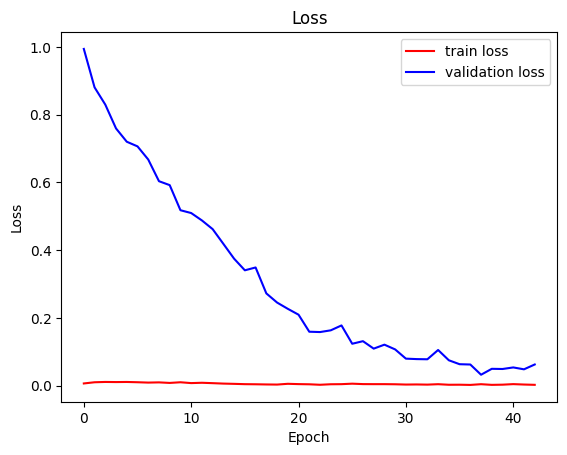

In [22]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
plt.plot(loss_history, color = 'red', label = 'train loss')
plt.plot(val_loss_history, color = 'blue', label = 'validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

591/591 [==============================] - 2s 4ms/step
predicted_price shape: (18896, 2)
real_price shape: (18896, 2)


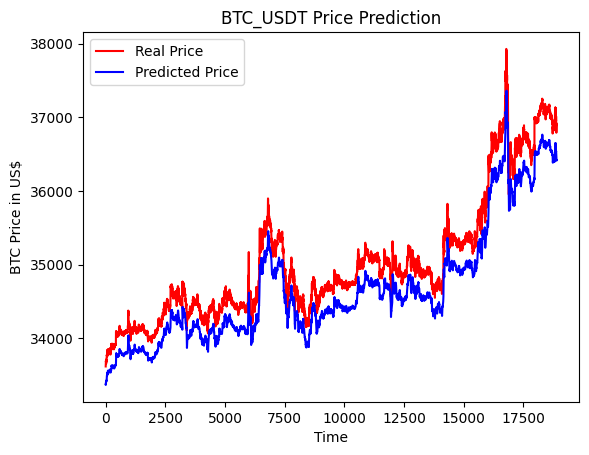

In [23]:
# Predict test data and revert the price to the original scale
predicted_price = regressor.predict(X_test)
predicted_price = sc_target.inverse_transform(predicted_price)[:-predicting_points]
print('predicted_price shape:',predicted_price.shape)
# predicted_price

real_price = sc_target.inverse_transform(y_test)[:-predicting_points]
print('real_price shape:',real_price.shape)
# real_price

plt.plot(real_price[:,0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[:,0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

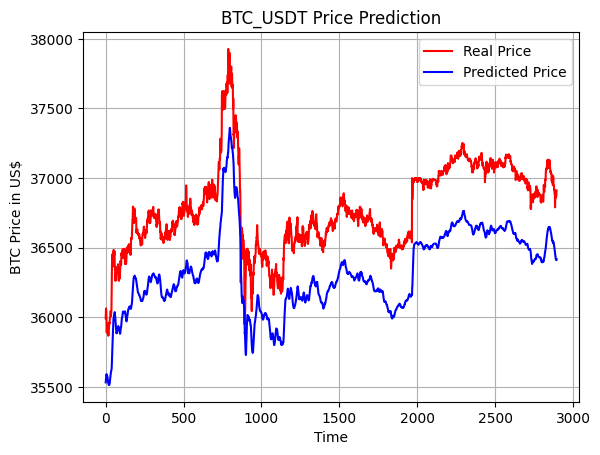

In [24]:
plt.plot(real_price[16000:, 0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[16000:, 0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.grid()
plt.show()

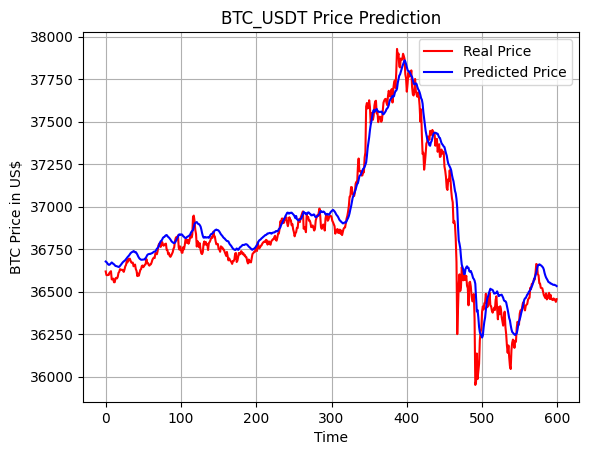

In [28]:
plt.plot(real_price[16400:17000, 0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[16400:17000, 0]+500, color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.grid()
plt.show()

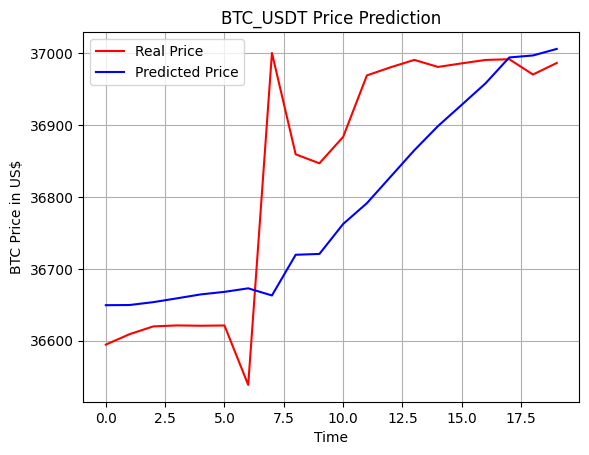

In [30]:
plt.plot(real_price[17960:17980, 0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[17960:17980, 0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.grid()
plt.show()

In [27]:
test_wmse = wmse_loss(real_price, predicted_price)
test_f1 = f1_metric(real_price, predicted_price)

print("test_wmse:",test_wmse)
print("test_f1:",float(test_f1))

test_wmse: 227785.57141751723
test_f1: 0.6520569920539856


2362/2362 [==============================] - 9s 4ms/step
predicted_price shape: (75575, 2)
real_price shape: (75575, 2)


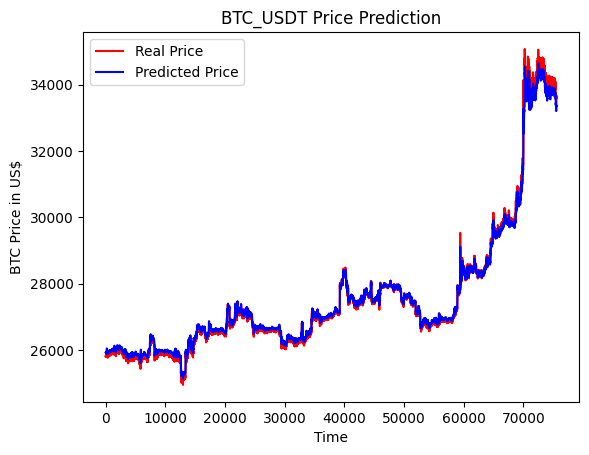

In [31]:
# Predict test data and revert the price to the original scale
predicted_price = regressor.predict(X_train)
predicted_price = sc_target.inverse_transform(predicted_price)[:-predicting_points]
print('predicted_price shape:',predicted_price.shape)
# predicted_price

real_price = sc_target.inverse_transform(y_train)[:-predicting_points]
print('real_price shape:',real_price.shape)
# real_price

plt.plot(real_price[:,0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[:,0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()